In [1]:
pip install keras-tuner

#2- Importing Required Libraries

In [2]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from sklearn.utils.class_weight import compute_class_weight
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50V2
from keras_tuner import RandomSearch
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import os

# 3- Data Preprocessing

In [3]:
labels = pd.read_csv('/content/drive/MyDrive/Dog Breed Identification project/labels.csv',index_col = 'id')

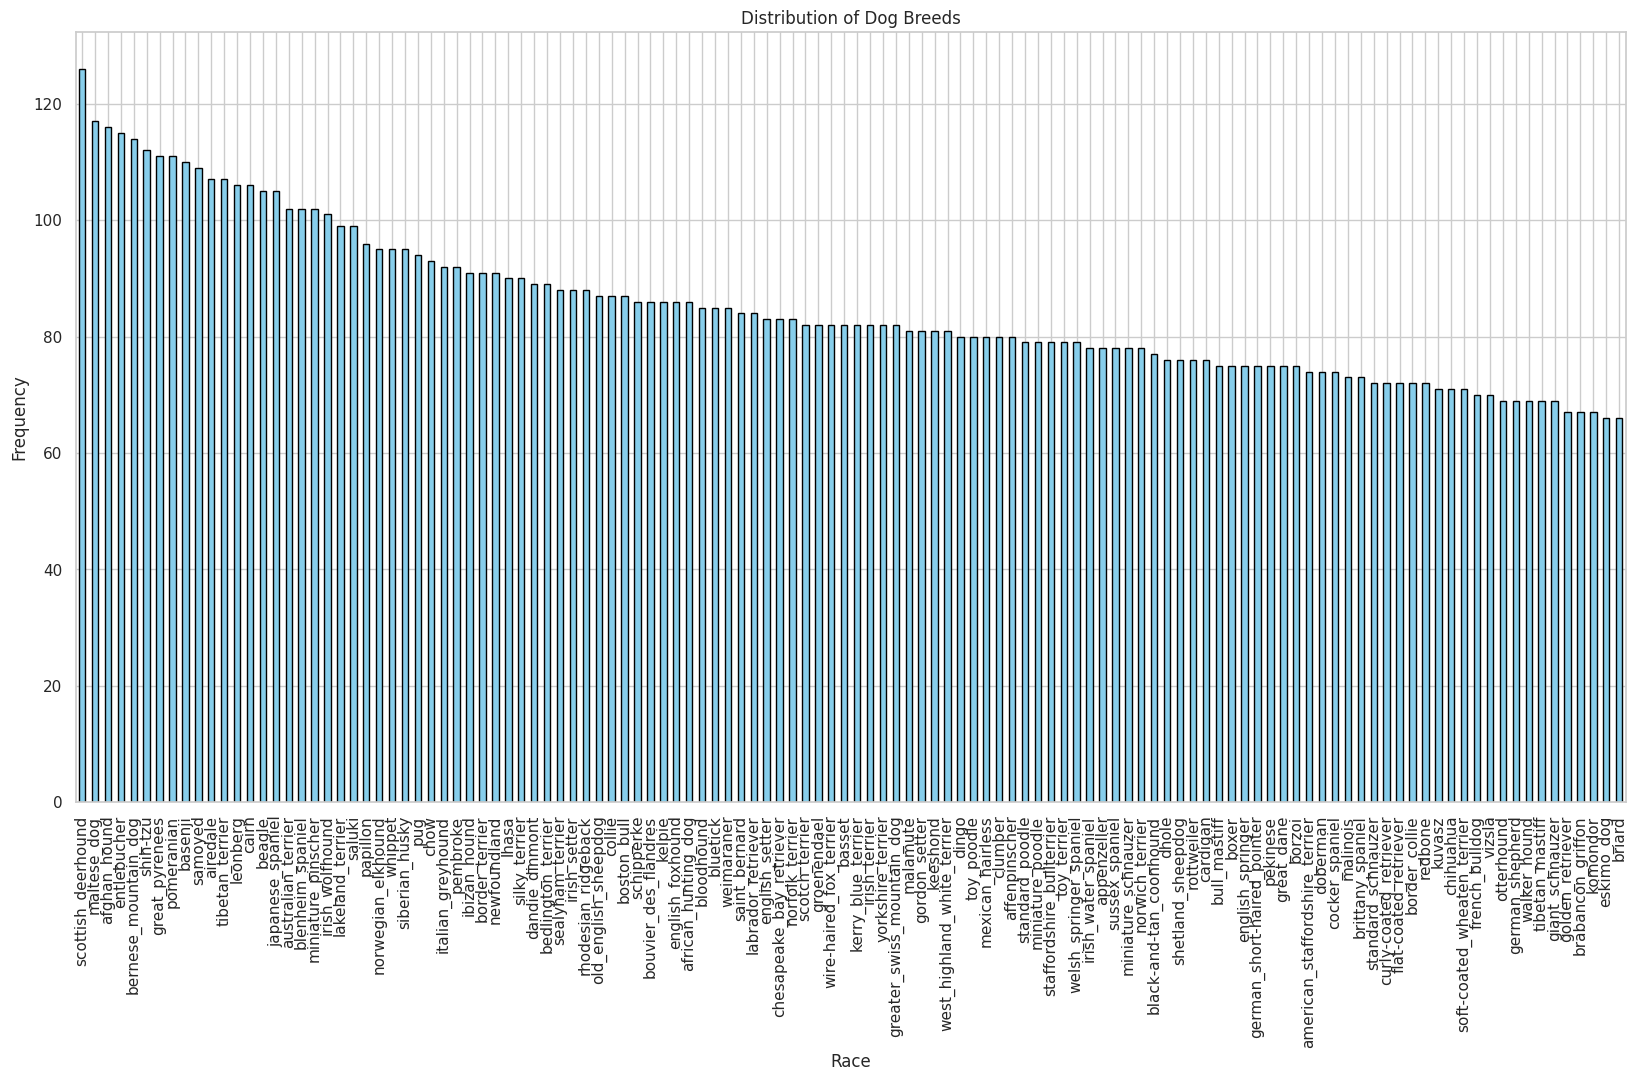

In [4]:
# Adjust Seaborn's visual style
sns.set(style="whitegrid")

# Draw the graph
labels["breed"].value_counts().plot(kind='bar', figsize=(20, 10), color='skyblue', edgecolor='black')

# Add title
plt.title('Distribution of Dog Breeds')
plt.xlabel('Race')
plt.ylabel('Frequency')

# Show
plt.show()


In [5]:
# find unique label values
unique_breeds = np.unique(labels['breed'])
print(unique_breeds)
print('number of dogs breeds: ',len(unique_breeds))

['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
 'black-and-tan_coonhound' 'blenheim_spaniel' 'bloodhound' 'bluetick'
 'border_collie' 'border_terrier' 'borzoi' 'boston_bull'
 'bouvier_des_flandres' 'boxer' 'brabancon_griffon' 'briard'
 'brittany_spaniel' 'bull_mastiff' 'cairn' 'cardigan'
 'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber' 'cocker_spaniel'
 'collie' 'curly-coated_retriever' 'dandie_dinmont' 'dhole' 'dingo'
 'doberman' 'english_foxhound' 'english_setter' 'english_springer'
 'entlebucher' 'eskimo_dog' 'flat-coated_retriever' 'french_bulldog'
 'german_shepherd' 'german_short-haired_pointer' 'giant_schnauzer'
 'golden_retriever' 'gordon_setter' 'great_dane' 'great_pyrenees'
 'greater_swiss_mountain_dog' 'groenendael' 'ibizan_hound' 'irish_setter'
 'irish_terrier' 'irish_water_spaniel' 'irish_wolfhound'
 'italian

In [6]:
# Define data set paths and parameters
folder_path = '/content/drive/MyDrive/Dog Breed Identification project/train/'
labels_path = '/content/drive/MyDrive/Dog Breed Identification project/labels.csv'


In [7]:
print("Folder path:", folder_path)
print("Labels path:", labels_path)


Folder path: /content/drive/MyDrive/Dog Breed Identification project/train/
Labels path: /content/drive/MyDrive/Dog Breed Identification project/labels.csv


In [8]:
print("Does folder exist?", os.path.exists(folder_path))
print("Does labels file exist?", os.path.exists(labels_path))


Does folder exist? True
Does labels file exist? True


In [9]:
num_images = len(os.listdir(folder_path))
print("Number of images in training set:", num_images)


Number of images in training set: 10223


In [10]:
# Define parameters
IMG_SIZE = 200
NUM_EPOCHS = 100

In [11]:
def process_label(label):
    """
    Takes a simple label (string) as an argument and returns a one-hot encoded target tensor.
    """
    one_hot = tf.equal(unique_breeds, label)
    one_hot = tf.cast(one_hot, tf.int32) # Data type conversion with TensorFlow
    return one_hot


In [12]:
def process_image(image_path,img_size=IMG_SIZE):
    """
    Takes an image path and requested image size, returns tensor version of an image
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image,channels=3) # turning into a tensor
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = tf.image.resize(image,size=[img_size,img_size]) # resizing

    return image

In [13]:
# Upload tags
labels = pd.read_csv(labels_path, index_col='id')

In [14]:
# Test the process_label function
test_label = unique_breeds[0] # take the first label
print("Test label:", test_label)
one_hot_label = process_label(test_label)
print("One hot encoded label:", one_hot_label)

# Test the process_image function
test_image_path = folder_path + os.listdir(folder_path)[0] # get path to first image
print("Test image path:", test_image_path)
processed_image = process_image(test_image_path)
print("Processed image shape:", processed_image.shape)


Test label: affenpinscher
One hot encoded label: tf.Tensor(
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0], shape=(120,), dtype=int32)
Test image path: /content/drive/MyDrive/Dog Breed Identification project/train/e79f822b26adace4455db1fcd94ab47e.jpg
Processed image shape: (200, 200, 3)


In [15]:
print("Data type of one hot encoded label:", one_hot_label.dtype)


Data type of one hot encoded label: <dtype: 'int32'>


In [16]:
# Start image and tag lists
dogs_images = []
image_labels = []

# Process all images
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        try:
            # Get tag
            image_id = filename.split('.')[0]
            breed = labels.loc[image_id, 'breed']

            # Upload and process the image
            image_path = os.path.join(folder_path, filename)
            image = process_image(image_path, IMG_SIZE)

            # Add to lists
            dogs_images.append(image)
            image_labels.append(breed)
        except Exception as e:
            print(f"An error occurred while processing the image: {filename}, Error: {e}")

# Convert image and tag lists to numpy arrays
dogs_images = np.array(dogs_images)
image_labels = np.array(image_labels)

# Printing information for control purposes
print(f"Number of images loaded: {len(dogs_images)}")
print(f"Number of labels loaded: {len(image_labels)}")

Number of images loaded: 10222
Number of labels loaded: 10222


In [17]:
# Print the first 5 labels
for i in range(5):
    print(f"Label {i}: {image_labels[i]}")

Label 0: schipperke
Label 1: bouvier_des_flandres
Label 2: german_shepherd
Label 3: siberian_husky
Label 4: japanese_spaniel


In [18]:
# Convert tags to one-hot encoded format
one_hot_labels = np.array([process_label(label).numpy() for label in image_labels])


In [19]:
# Separate data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(dogs_images, one_hot_labels, test_size=0.2, random_state=42)

# Print sizes for control purposes
print("Training data size:", len(X_train))
print("Validation data size:", len(X_val))

Training data size: 8177
Validation data size: 2045


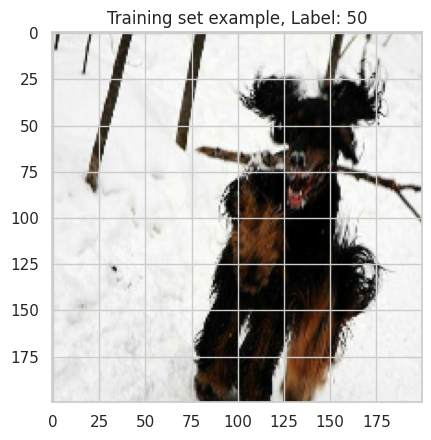

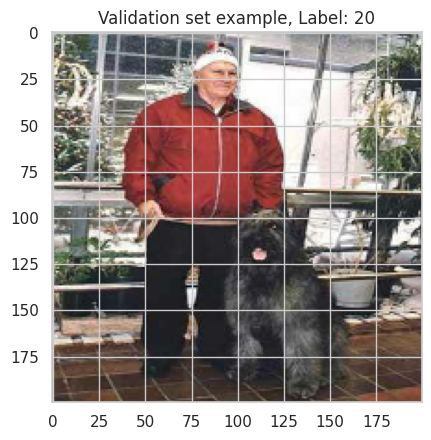

In [20]:
# Visualize a random example from the training set
random_index = np.random.randint(0, len(X_train))
plt.imshow(X_train[random_index])
plt.title(f"Training set example, Label: {np.argmax(y_train[random_index])}")
plt.show()

# Visualize a random instance from the validation set
random_index = np.random.randint(0, len(X_val))
plt.imshow(X_val[random_index])
plt.title(f"Validation set example, Label: {np.argmax(y_val[random_index])}")
plt.show()

#4- Building a Model

In [21]:
# Update model structure
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Make some top layers trainable
for layer in base_model.layers[:150]:
    layer.trainable = False

# Rebuild the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(120, activation='softmax')
])

# Compile model
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


94668760/94668760 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               61560     
                                                                 
Total params: 24675448 (94.13 MB)
Trainable params: 16344

## Model training

In [22]:
# Check the first training image
print("Dimensions of the first training image:", X_train[0].shape)
print("Data type of the first training image:", X_train[0].dtype)

# Check first verification image
print("Dimensions of the first verification image:", X_val[0].shape)
print("Data type of the first validation image:", X_val[0].dtype)


Dimensions of the first training image: (200, 200, 3)
Data type of the first training image: float32
Dimensions of the first verification image: (200, 200, 3)
Data type of the first validation image: float32


In [23]:
# Check the first training label
print("First training label:", y_train[0])
print("Size of the first training label:", y_train[0].shape)

# Check the first verification tag
print("First validation tag:", y_val[0])
print("Size of the first validation tag:", y_val[0].shape)


First training label: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0]
Size of the first training label: (120,)
First validation tag: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
Size of the first validation tag: (120,)


In [24]:
# Check the ranges of image data
print("Training images min-max:", X_train.min(), X_train.max())
print("Validation images min-max:", X_val.min(), X_val.max())


Training images min-max: 0.0 1.0
Validation images min-max: 0.0 1.0


In [25]:
# More balanced data augmentation parameters
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data augmentation application
train_data_gen = data_gen.flow(X_train, y_train, batch_size=32)




In [26]:
# Convert one-hot encoded tags to integer format
y_integers = np.argmax(y_train, axis=1)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
class_weight_dict = dict(enumerate(class_weights))

# Use these class weights during model training



In [27]:
# Stopping early and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Reducing the learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Create callback list
callbacks_list = [early_stopping, checkpoint, reduce_lr]

In [28]:
# Model training
history = model.fit(
    train_data_gen,
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=callbacks_list
)

Epoch 1/50
255/255 [==============================] - ETA: 0s - loss: 4.4665 - accuracy: 0.1914

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


255/255 [==============================] - 86s 274ms/step - loss: 4.4665 - accuracy: 0.1914 - val_loss: 2.4596 - val_accuracy: 0.5389 - lr: 1.0000e-04
Epoch 2/50
255/255 [==============================] - 68s 268ms/step - loss: 2.8571 - accuracy: 0.4518 - val_loss: 2.1271 - val_accuracy: 0.5936 - lr: 1.0000e-04
Epoch 3/50
255/255 [==============================] - 69s 269ms/step - loss: 2.3057 - accuracy: 0.5608 - val_loss: 1.9813 - val_accuracy: 0.6191 - lr: 1.0000e-04
Epoch 4/50
255/255 [==============================] - 68s 267ms/step - loss: 1.9634 - accuracy: 0.6377 - val_loss: 1.9621 - val_accuracy: 0.6386 - lr: 1.0000e-04
Epoch 5/50
255/255 [==============================] - 69s 268ms/step - loss: 1.7145 - accuracy: 0.6893 - val_loss: 1.9422 - val_accuracy: 0.6474 - lr: 1.0000e-04
Epoch 6/50
255/255 [==============================] - 68s 266ms/step - loss: 1.5080 - accuracy: 0.7344 - val_loss: 1.9794 - val_accuracy: 0.6484 - lr: 1.0000e-04
Epoch 7/50
255/255 [===================

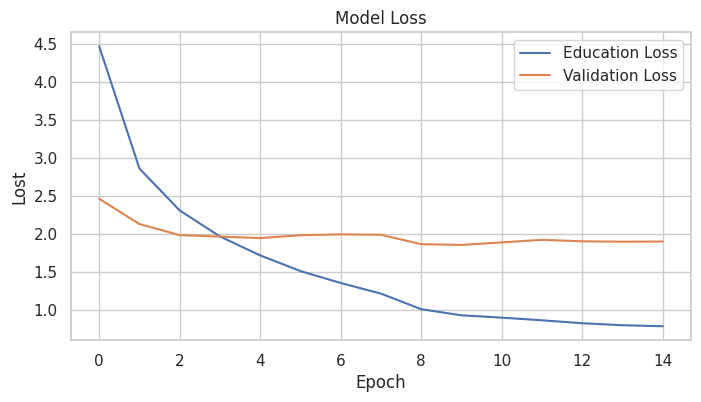

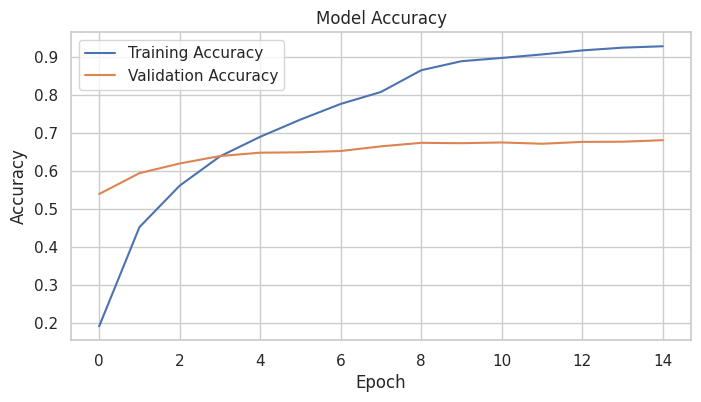

In [29]:
# Loss charts
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Education Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Lost')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Accuracy graphs
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

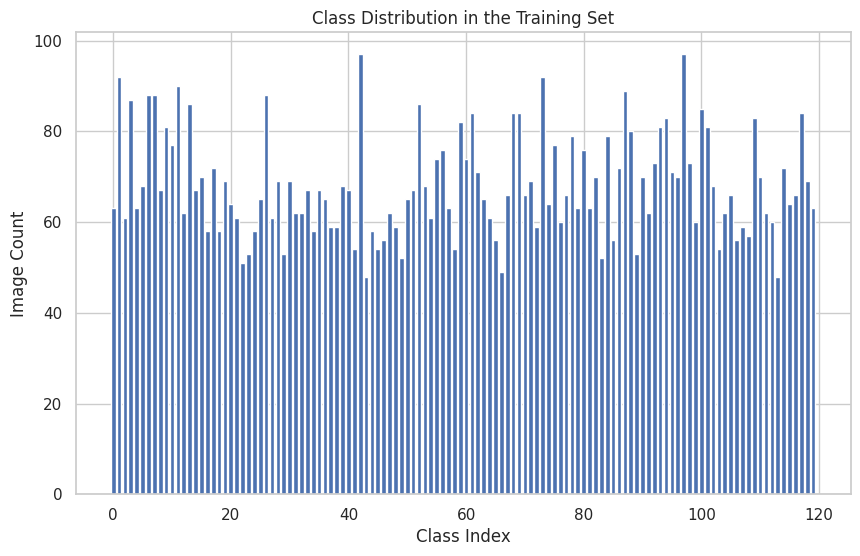

In [30]:
# Check class distribution in the training set
class_counts = np.sum(y_train, axis=0)
plt.figure(figsize=(10, 6))
plt.bar(range(len(class_counts)), class_counts)
plt.title('Class Distribution in the Training Set')
plt.xlabel('Class Index')
plt.ylabel('Image Count')
plt.show()

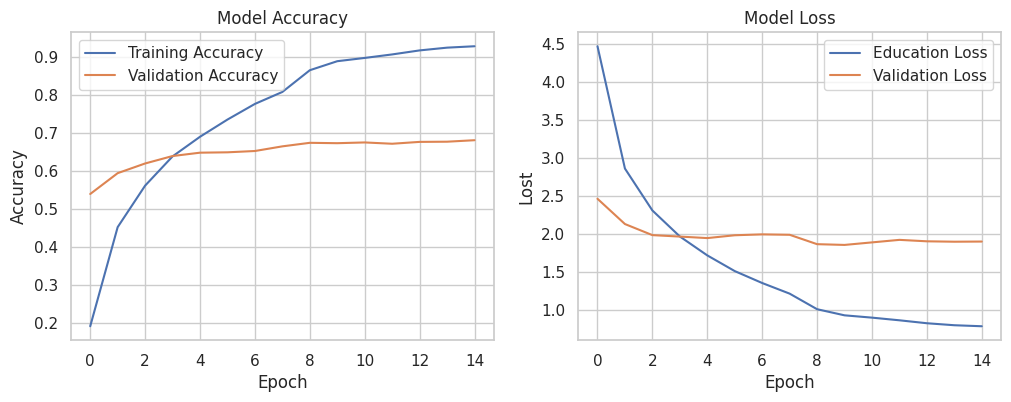

In [31]:
# Training and Verification Accuracy Graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Training and Verification Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Education Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Lost')
plt.legend()

plt.show()


#5- Hyper-parameter Optimization

In [32]:
def build_model(hp):
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(units=hp.Int('units', min_value=256, max_value=512, step=128), activation='relu'),
        Dropout(rate=hp.Float('dropout', min_value=0.3, max_value=0.5, step=0.1)),
        Dense(120, activation='softmax')
    ])

    model.compile(optimizer=RMSprop(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define and run the tuner to do the hyperparameter optimization
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='model_tuning',
    project_name='dog_breed_classification'
)

tuner.search(train_data_gen,
             validation_data=(X_val, y_val),
             epochs=10,
             callbacks=[early_stopping])


Trial 5 Complete [00h 21m 11s]
val_accuracy: 0.5711491505304972

Best val_accuracy So Far: 0.5947840213775635
Total elapsed time: 02h 00m 13s
